In [25]:
import datetime
import os.path as osp
import platform
import pickle as pkl

import matplotlib
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import global_mean_pool

from pyg_ssl.args import parse_args
from pyg_ssl.mlpf import MLPF
from pyg_ssl.training_mlpf import training_loop_mlpf
from pyg_ssl.training_VICReg import training_loop_VICReg
from pyg_ssl.utils import CLUSTERS_X, TRACKS_X, data_split, load_VICReg, save_MLPF, save_VICReg, distinguish_PFelements
from pyg_ssl.VICReg import DECODER, ENCODER

import tqdm
matplotlib.use("Agg")
mplhep.style.use(mplhep.styles.CMS)

# Ignore divide by 0 errors
np.seterr(divide="ignore", invalid="ignore")

# define the global base device
if torch.cuda.device_count():
    device = torch.device("cuda:0")
    print(f"Will use {torch.cuda.get_device_name(device)}")
else:
    device = "cpu"
    print("Will use cpu")

Will use NVIDIA GeForce GTX 1080 Ti


In [2]:
# load the clic dataset
data_VICReg_train, data_VICReg_valid, data_mlpf_train, data_mlpf_valid, data_test_qcd, data_test_ttbar = data_split(
    "/pfclicvol/data/clic_edm4hep", "quick"
)

Will use data split mode `quick`
Will use 25843 events to train VICReg
Will use 2871 events to validate VICReg
Will use 6461 events to train MLPF
Will use 718 events to validate MLPF


In [3]:
embedding_dim_VICReg = 256
width_encoder = 256 
num_convs = 3
expand_dim = 256
width_decoder = 256

encoder_model_kwargs = {
    "embedding_dim": embedding_dim_VICReg,
    "width": width_encoder,
    "num_convs": num_convs,
    "space_dim": 4,
    "propagate_dim": 22,
    "k": 32,
}

decoder_model_kwargs = {
    "input_dim": embedding_dim_VICReg,
    "output_dim": expand_dim,
    "width": width_decoder,
}

encoder = ENCODER(**encoder_model_kwargs).to(device)
decoder = DECODER(**decoder_model_kwargs).to(device)

In [4]:
class VICReg(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(VICReg, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, tracks, clusters):

        ### encode
        embedding_tracks, embedding_clusters = self.encoder(tracks, clusters)
        
        ### decode
        out_tracks, out_clusters = self.decoder(embedding_tracks, embedding_clusters)

        return out_tracks, out_clusters

In [5]:
vicreg = VICReg(encoder, decoder)
vicreg

VICReg(
  (encoder): ENCODER(
    (nn1): Sequential(
      (0): Linear(in_features=14, out_features=256, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=256, out_features=256, bias=True)
    )
    (nn2): Sequential(
      (0): Linear(in_features=15, out_features=256, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=256, out_features=256, bias=True)
    )
    (conv): ModuleList(
      (0): GravNetConv(256, 256, k=32)
      (1): GravNetConv(256, 256, k=32)
      (2): GravNetConv(256, 256, k=32)
    )
  )
  (decoder): DECODER(
    (expander): Sequential(
      (0): Linear(in_features=256, out_featur

In [6]:
batch_size_VICReg = 500
train_loader = torch_geometric.loader.DataLoader(data_VICReg_train, batch_size_VICReg)
valid_loader = torch_geometric.loader.DataLoader(data_VICReg_valid, batch_size_VICReg)

In [7]:
for batch in train_loader:
    # make transformation
    tracks, clusters = distinguish_PFelements(batch.to(device))

    # run through VICReg
    out_tracks, out_clusters = vicreg(tracks, clusters)

    # POOLING
    pooled_tracks = global_mean_pool(out_tracks, tracks.batch)
    pooled_clusters = global_mean_pool(out_clusters, clusters.batch)
    break

In [8]:
F.mse_loss(pooled_tracks, pooled_clusters)

tensor(6.7567, device='cuda:0', grad_fn=<MseLossBackward0>)

In [9]:
class invar_loss(nn.Module):

    def __init__(self):
        super(invar_loss, self).__init__()

    def forward(self, x, y):
        return F.mse_loss(x, y)
    
class var_loss(nn.Module):

    def __init__(self):
        super(var_loss, self).__init__()

    def forward(self, x, y, epsilon=1e-3):
        std_x = torch.sqrt(x.var(dim=0) + epsilon)
        std_y = torch.sqrt(y.var(dim=0) + epsilon)
        var_loss = torch.mean(F.relu(1 - std_x)) + torch.mean(F.relu(1 - std_y))
        
        return var_loss    
    
class cross_loss(nn.Module):

    def __init__(self):
        super(cross_loss, self).__init__()

    def forward(self, x, y, lmbd=0.01):
        bs = x.size(0)
        emb = x.size(1)

        xNorm = (x - x.mean(0)) / x.std(0)
        yNorm = (y - y.mean(0)) / y.std(0)

        crossCorMat = (xNorm.T @ yNorm) / bs
        cross_loss = (crossCorMat * lmbd - torch.eye(emb, device=torch.device(device)) * lmbd).pow(2).sum()

        return cross_loss

In [10]:
crit_invar = invar_loss()
crit_var = var_loss()
crit_cross = cross_loss()

In [11]:
print(f"invar_loss = {crit_invar(pooled_tracks, pooled_clusters)}")
print(f"var_loss   = {crit_var(pooled_tracks, pooled_clusters)}")
print(f"cross_loss = {crit_cross(pooled_tracks, pooled_clusters)}")

invar_loss = 6.756711483001709
var_loss   = 1.095689058303833
cross_loss = 0.03437644988298416


In [12]:
crit_invar = invar_loss()
crit_var = var_loss()
crit_cross = cross_loss()

import mdmm
max_ = 0.1

constraints = []
constraints.append(mdmm.MaxConstraint(lambda: crit_var(pooled_tracks, pooled_clusters), max_))
constraints.append(mdmm.MaxConstraint(lambda: crit_cross(pooled_tracks, pooled_clusters), max_))

# Train

In [35]:
encoder = ENCODER(**encoder_model_kwargs).to(device)
decoder = DECODER(**decoder_model_kwargs).to(device)
vicreg = VICReg(encoder, decoder)

mdmm_module = mdmm.MDMM(constraints)
opt = mdmm_module.make_optimizer(vicreg.parameters(), lr=2e-3)

In [36]:
mdmm_ = 1

n_epochs = 200
u = 0.01
v = 0.01
stale_epochs = 0
best_val_loss_tot = 99999999

# initialize loss counters
t_losses, v_losses = [], []
for j in range(n_epochs):
    
    # train loop
    is_train = True
    vicreg.train()
    loader = train_loader    
    losses, var_losses, invar_losses, cross_losses = 0.0, 0.0, 0.0, 0.0
    for i, batch in tqdm.tqdm(enumerate(loader), total=len(loader)):

        # seperate tracks from clusters
        tracks, clusters = distinguish_PFelements(batch.to(device))
        # run VICReg
        out_tracks, out_clusters = vicreg(tracks, clusters)
        
        # POOLING
        pooled_tracks = global_mean_pool(out_tracks, tracks.batch)
        pooled_clusters = global_mean_pool(out_clusters, clusters.batch)

        # compute loss & update parameters
        if mdmm_:
            loss = crit_invar(pooled_tracks, pooled_clusters)
            mdmm_return = mdmm_module(loss)            
            opt.zero_grad()
            mdmm_return.value.backward()
            opt.step()
            
        else:
            loss = u * crit_var(pooled_tracks, pooled_clusters) + v * crit_invar(pooled_tracks, pooled_clusters) + crit_cross(pooled_tracks, pooled_clusters)
            for param in encoder.parameters():
                param.grad = None
            for param in decoder.parameters():
                param.grad = None
            loss.backward()
            optimizer.step()            

        losses += loss.detach()

    t_losses.append(losses.cpu().item() / (len(loader)))

    # valid loop
    is_train = False
    vicreg.eval()
    loader = valid_loader
    losses = 0.0
    for i, batch in tqdm.tqdm(enumerate(loader), total=len(loader)):

        # seperate tracks from clusters
        tracks, clusters = distinguish_PFelements(batch.to(device))
        # run VICReg
        out_tracks, out_clusters = vicreg(tracks, clusters)
        
        # POOLING
        pooled_tracks = global_mean_pool(out_tracks, tracks.batch)
        pooled_clusters = global_mean_pool(out_clusters, clusters.batch)

        # compute loss
        if mdmm_:
            loss = crit_invar(pooled_tracks, pooled_clusters)         
        else:
            loss = u * crit_var(pooled_tracks, pooled_clusters) + v * crit_invar(pooled_tracks, pooled_clusters) + crit_cross(pooled_tracks, pooled_clusters)

        losses += loss.detach()

    v_losses.append(losses.cpu().item() / (len(loader)))   
    
    if v_losses[j] < best_val_loss_tot:
        stale_epochs = 0
        best_val_loss_tot = v_losses[j]
        torch.save(vicreg.state_dict(), f"/pfclicvol/vicreg.pth")
    else:
        stale_epochs += 1
        
    print(f"{j}/{n_epochs} --- Train: tot_loss = {t_losses[j]:.2f} - Valid: tot_loss = {v_losses[j]:.2f} - stale={stale_epochs}") 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.11it/s]


Train: tot_loss = 25.29 - Valid: tot_loss = 6.10 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


Train: tot_loss = 2.73 - Valid: tot_loss = 2.14 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.83it/s]


Train: tot_loss = 11.75 - Valid: tot_loss = 1.98 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.85it/s]


Train: tot_loss = 1.76 - Valid: tot_loss = 1.78 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]


Train: tot_loss = 1.71 - Valid: tot_loss = 1.67 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.87it/s]


Train: tot_loss = 1.70 - Valid: tot_loss = 1.56 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


Train: tot_loss = 1.72 - Valid: tot_loss = 1.64 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.11it/s]


Train: tot_loss = 1.71 - Valid: tot_loss = 1.69 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]


Train: tot_loss = 1.72 - Valid: tot_loss = 1.66 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.89it/s]


Train: tot_loss = 1.71 - Valid: tot_loss = 1.69 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.89it/s]


Train: tot_loss = 1.72 - Valid: tot_loss = 1.70 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.82it/s]


Train: tot_loss = 1.70 - Valid: tot_loss = 1.67 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.93it/s]


Train: tot_loss = 1.71 - Valid: tot_loss = 1.64 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.86it/s]


Train: tot_loss = 1.71 - Valid: tot_loss = 1.68 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.87it/s]


Train: tot_loss = 1.71 - Valid: tot_loss = 1.67 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.90it/s]


Train: tot_loss = 1.71 - Valid: tot_loss = 1.64 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.94it/s]


Train: tot_loss = 1.71 - Valid: tot_loss = 1.65 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


Train: tot_loss = 1.71 - Valid: tot_loss = 1.66 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.90it/s]


Train: tot_loss = 1.70 - Valid: tot_loss = 1.66 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.92it/s]


Train: tot_loss = 1.70 - Valid: tot_loss = 1.63 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


Train: tot_loss = 1.70 - Valid: tot_loss = 1.66 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


Train: tot_loss = 1.70 - Valid: tot_loss = 1.64 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.92it/s]


Train: tot_loss = 1.70 - Valid: tot_loss = 1.66 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.90it/s]


Train: tot_loss = 1.70 - Valid: tot_loss = 1.67 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.88it/s]


Train: tot_loss = 1.69 - Valid: tot_loss = 1.64 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.83it/s]


Train: tot_loss = 1.68 - Valid: tot_loss = 1.62 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.83it/s]


Train: tot_loss = 1.70 - Valid: tot_loss = 1.67 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.80it/s]


Train: tot_loss = 1.69 - Valid: tot_loss = 1.68 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.89it/s]


Train: tot_loss = 1.68 - Valid: tot_loss = 1.63 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.02it/s]


Train: tot_loss = 1.70 - Valid: tot_loss = 1.69 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.09it/s]


Train: tot_loss = 1.69 - Valid: tot_loss = 1.68 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


Train: tot_loss = 1.69 - Valid: tot_loss = 1.67 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.88it/s]


Train: tot_loss = 1.69 - Valid: tot_loss = 1.68 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.87it/s]


Train: tot_loss = 1.69 - Valid: tot_loss = 1.67 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.90it/s]


Train: tot_loss = 1.68 - Valid: tot_loss = 1.64 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


Train: tot_loss = 1.67 - Valid: tot_loss = 1.63 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


Train: tot_loss = 1.68 - Valid: tot_loss = 1.62 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.83it/s]


Train: tot_loss = 1.66 - Valid: tot_loss = 1.58 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.86it/s]


Train: tot_loss = 1.65 - Valid: tot_loss = 1.56 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.80it/s]


Train: tot_loss = 1.66 - Valid: tot_loss = 1.67 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]


Train: tot_loss = 1.67 - Valid: tot_loss = 1.62 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


Train: tot_loss = 1.66 - Valid: tot_loss = 1.56 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.87it/s]


Train: tot_loss = 1.65 - Valid: tot_loss = 1.61 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.93it/s]


Train: tot_loss = 1.66 - Valid: tot_loss = 1.59 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.94it/s]


Train: tot_loss = 1.66 - Valid: tot_loss = 1.60 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.92it/s]


Train: tot_loss = 1.65 - Valid: tot_loss = 1.60 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.88it/s]


Train: tot_loss = 1.64 - Valid: tot_loss = 1.59 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.92it/s]


Train: tot_loss = 1.64 - Valid: tot_loss = 1.58 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.82it/s]


Train: tot_loss = 1.65 - Valid: tot_loss = 1.58 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]


Train: tot_loss = 1.64 - Valid: tot_loss = 1.60 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.89it/s]


Train: tot_loss = 1.64 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.85it/s]


Train: tot_loss = 1.64 - Valid: tot_loss = 1.53 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


Train: tot_loss = 1.63 - Valid: tot_loss = 1.59 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.59 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.81it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.61 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.94it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.59 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.83it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.58 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.58 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.59 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.95it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.11it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.58 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.93it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.60 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.59 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.12it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.53 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.11it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.73it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.55 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.62it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.84it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.56 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.83it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.94it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.54 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.11it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.54 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.12it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.55 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.10it/s]


Train: tot_loss = 1.60 - Valid: tot_loss = 1.56 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.09it/s]


Train: tot_loss = 1.60 - Valid: tot_loss = 1.50 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.12it/s]


Train: tot_loss = 1.60 - Valid: tot_loss = 1.54 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.95it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.56 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.82it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.83it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.62 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.87it/s]


Train: tot_loss = 1.63 - Valid: tot_loss = 1.62 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.58 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.19it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.59 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.53 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.80it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.58 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.79it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.62 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.85it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.58 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.58 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.84it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.61 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.58 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


Train: tot_loss = 1.63 - Valid: tot_loss = 1.96 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.80it/s]


Train: tot_loss = 2.08 - Valid: tot_loss = 2.76 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.02it/s]


Train: tot_loss = 2.18 - Valid: tot_loss = 1.60 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.14it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.58 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


Train: tot_loss = 1.63 - Valid: tot_loss = 1.63 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.95it/s]


Train: tot_loss = 1.63 - Valid: tot_loss = 1.60 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.13it/s]


Train: tot_loss = 1.63 - Valid: tot_loss = 1.60 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


Train: tot_loss = 1.63 - Valid: tot_loss = 1.54 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.89it/s]


Train: tot_loss = 1.63 - Valid: tot_loss = 1.59 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


Train: tot_loss = 1.63 - Valid: tot_loss = 1.60 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.13it/s]


Train: tot_loss = 1.63 - Valid: tot_loss = 1.59 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.95it/s]


Train: tot_loss = 1.63 - Valid: tot_loss = 1.59 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.09it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.59 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.85it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.58 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.92it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.56 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.93it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.60 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.12it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.56 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.95it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.58 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.16it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.63 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.13it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.61 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.09it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.61 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.55 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.60 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.06it/s]


Train: tot_loss = 1.62 - Valid: tot_loss = 1.62 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.06it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.60 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.09it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.59 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.89it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.61 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.90it/s]


Train: tot_loss = 1.61 - Valid: tot_loss = 1.60 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.15it/s]


Train: tot_loss = 1.60 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.17it/s]


Train: tot_loss = 1.57 - Valid: tot_loss = 1.48 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.09it/s]


Train: tot_loss = 1.45 - Valid: tot_loss = 1.39 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


Train: tot_loss = 1.47 - Valid: tot_loss = 1.48 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.11it/s]


Train: tot_loss = 1.47 - Valid: tot_loss = 1.45 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.95it/s]


Train: tot_loss = 1.47 - Valid: tot_loss = 1.48 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


Train: tot_loss = 1.48 - Valid: tot_loss = 1.43 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


Train: tot_loss = 1.48 - Valid: tot_loss = 1.46 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.93it/s]


Train: tot_loss = 1.49 - Valid: tot_loss = 1.44 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.18it/s]


Train: tot_loss = 1.49 - Valid: tot_loss = 1.43 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.82it/s]


Train: tot_loss = 1.49 - Valid: tot_loss = 1.43 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.71it/s]


Train: tot_loss = 1.50 - Valid: tot_loss = 1.42 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.87it/s]


Train: tot_loss = 1.50 - Valid: tot_loss = 1.39 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.88it/s]


Train: tot_loss = 1.50 - Valid: tot_loss = 1.44 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.82it/s]


Train: tot_loss = 1.50 - Valid: tot_loss = 1.47 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.87it/s]


Train: tot_loss = 1.50 - Valid: tot_loss = 1.51 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.94it/s]


Train: tot_loss = 1.50 - Valid: tot_loss = 1.53 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.94it/s]


Train: tot_loss = 1.51 - Valid: tot_loss = 1.47 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


Train: tot_loss = 1.51 - Valid: tot_loss = 1.50 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.89it/s]


Train: tot_loss = 1.50 - Valid: tot_loss = 1.55 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.93it/s]


Train: tot_loss = 1.51 - Valid: tot_loss = 1.48 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.88it/s]


Train: tot_loss = 1.50 - Valid: tot_loss = 1.44 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


Train: tot_loss = 1.50 - Valid: tot_loss = 1.39 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.77it/s]


Train: tot_loss = 1.51 - Valid: tot_loss = 1.42 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


Train: tot_loss = 1.51 - Valid: tot_loss = 1.42 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.76it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.47 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.95it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.46 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.86it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.43 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.43 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.86it/s]


Train: tot_loss = 1.51 - Valid: tot_loss = 1.47 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.87it/s]


Train: tot_loss = 1.53 - Valid: tot_loss = 1.48 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


Train: tot_loss = 1.53 - Valid: tot_loss = 1.49 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.49 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.51 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.85it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.53 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.89it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.49 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.10it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.53 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.89it/s]


Train: tot_loss = 1.51 - Valid: tot_loss = 1.51 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.93it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.51 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.74it/s]


Train: tot_loss = 1.51 - Valid: tot_loss = 1.51 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.95it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.52 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.70it/s]


Train: tot_loss = 1.53 - Valid: tot_loss = 1.49 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


Train: tot_loss = 1.51 - Valid: tot_loss = 1.48 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


Train: tot_loss = 1.53 - Valid: tot_loss = 1.48 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.94it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.51 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.90it/s]


Train: tot_loss = 1.50 - Valid: tot_loss = 1.52 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.80it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.51 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


Train: tot_loss = 1.53 - Valid: tot_loss = 1.54 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.09it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.51 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.89it/s]


Train: tot_loss = 1.53 - Valid: tot_loss = 1.48 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.48 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.55 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.93it/s]


Train: tot_loss = 1.50 - Valid: tot_loss = 1.49 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.89it/s]


Train: tot_loss = 1.59 - Valid: tot_loss = 1.50 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.88it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.51 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.54 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


Train: tot_loss = 1.54 - Valid: tot_loss = 1.55 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.78it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.51 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.51 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.12it/s]


Train: tot_loss = 1.53 - Valid: tot_loss = 1.56 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.53 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.56 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.82it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.47 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.77it/s]


Train: tot_loss = 1.49 - Valid: tot_loss = 1.57 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.92it/s]


Train: tot_loss = 1.51 - Valid: tot_loss = 1.53 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.95it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.54 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.80it/s]


Train: tot_loss = 1.51 - Valid: tot_loss = 1.55 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.80it/s]


Train: tot_loss = 1.51 - Valid: tot_loss = 1.54 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.82it/s]


Train: tot_loss = 1.53 - Valid: tot_loss = 1.54 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.86it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.52 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.51 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.89it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.47 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


Train: tot_loss = 1.51 - Valid: tot_loss = 1.51 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.93it/s]


Train: tot_loss = 1.52 - Valid: tot_loss = 1.52 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


Train: tot_loss = 1.51 - Valid: tot_loss = 1.49 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.94it/s]


Train: tot_loss = 1.49 - Valid: tot_loss = 1.48 - stale=0


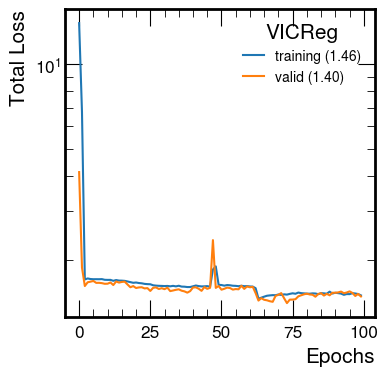

In [53]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

# make total loss plot
fig, ax = plt.subplots(figsize=(4,4))

result = np.mean(np.array(t_losses).reshape(-1, 2), axis=1)
ax.plot(range(len(result)), result, label="training ({:.2f})".format(result.min()))

result = np.mean(np.array(v_losses).reshape(-1, 2), axis=1)
ax.plot(range(len(result)), result, label="valid ({:.2f})".format(result.min()))

ax.set_xlabel("Epochs")
ax.set_ylabel("Total Loss")
ax.set_yscale("log")
ax.legend(title="VICReg", loc="best", title_fontsize=15, fontsize=10)

In [43]:
torch.save(vicreg.state_dict(), f"/pfclicvol/vicreg.pth")

with open(f"/pfclicvol/vicreg_decoder_model_kwargs.pkl", "wb") as f:  # dump model architecture
    pkl.dump(decoder_model_kwargs, f, protocol=pkl.HIGHEST_PROTOCOL)
    
with open(f"/pfclicvol/vicreg_encoder_model_kwargs.pkl", "wb") as f:  # dump model architecture
    pkl.dump(encoder_model_kwargs, f, protocol=pkl.HIGHEST_PROTOCOL)    

In [57]:
tracks

DataBatch(x=[13641, 14], ygen=[13641, 5], ygen_id=[13641], ycand=[13641, 5], ycand_id=[13641], batch=[13641])

In [59]:
vicreg.encoder

ENCODER(
  (nn1): Sequential(
    (0): Linear(in_features=14, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=256, out_features=256, bias=True)
  )
  (nn2): Sequential(
    (0): Linear(in_features=15, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv): ModuleList(
    (0): GravNetConv(256, 256, k=32)
    (1): GravNetConv(256, 256, k=32)
    (2): GravNetConv(256, 256, k=32)
  )
)

Text(0, 0.5, 'Covariance Loss')

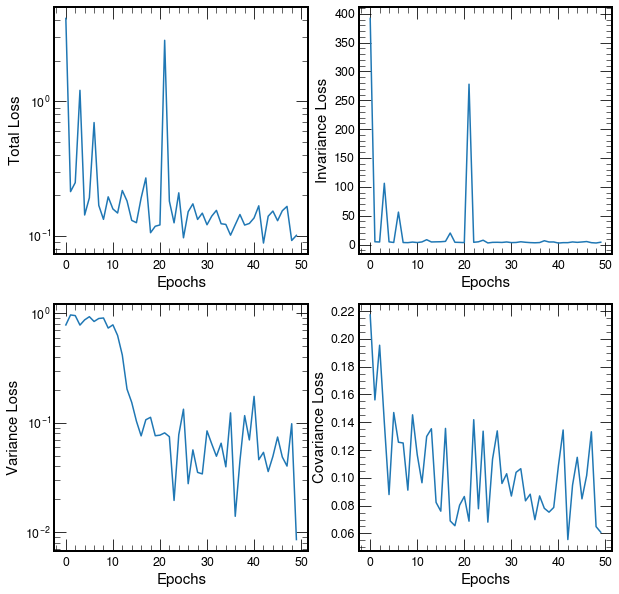

In [183]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

# make total loss plot
result = np.mean(tot_loss[:500].reshape(-1, 10), axis=1)
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].plot(range(len(result)), result, label="training ({:.2f})".format(result.min()))
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("Total Loss")
ax[0,0].set_yscale("log")
# ax[0,0].legend(title="VICReg", loc="best", title_fontsize=15, fontsize=10)

# make variance loss plot
result = np.mean(np.array(var_losses[:500]).reshape(-1, 10), axis=1)
ax[1,0].plot(range(len(result)), result, label="training ({:.2f})".format(result.min()))
ax[1,0].set_xlabel("Epochs")
ax[1,0].set_ylabel("Variance Loss")
ax[1,0].set_yscale("log")
# ax[1,0].legend(title="VICReg", loc="best", title_fontsize=15, fontsize=10)

# make invariance loss plot
result = np.mean(np.array(invar_losses[:500]).reshape(-1, 10), axis=1)
ax[0,1].plot(range(len(result)), result, label="training ({:.2f})".format(np.array(result).min()))
ax[0,1].set_xlabel("Epochs")
ax[0,1].set_ylabel("Invariance Loss")
# ax[0,1].legend(title="VICReg", loc="best", title_fontsize=15, fontsize=10)

# make covariance loss plot
result = np.mean(np.array(cross_losses[:500]).reshape(-1, 10), axis=1)
ax[1,1].plot(range(len(result)), result, label="training ({:.2f})".format(np.array(result).min()))
ax[1,1].set_xlabel("Epochs")
ax[1,1].set_ylabel("Covariance Loss")
# ax[1,1].legend(title="VICReg", loc="best", title_fontsize=15, fontsize=10)